In [2]:
# Activate intractive functionality of matplotlib
%matplotlib ipympl
# Activate auto reload 
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
# import libraries
import os
import numpy as np
import subprocess
from ipywidgets import widgets
from IPython.display import display
from ipywidgets import fixed, interact_manual
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Arial']
rcParams['svg.fonttype'] = 'none'

# Local module and scripts
from pyccapt.calibration.calibration import widgets as wd
from pyccapt.calibration.data_tools import data_tools, data_loadcrop, dataset_path_qt
from pyccapt.calibration.tutorials.tutorials_helpers import helper_calibration
from pyccapt.calibration.tutorials.tutorials_helpers import helper_data_loader
from pyccapt.calibration.tutorials.tutorials_helpers import helper_temporal_crop
from pyccapt.calibration.tutorials.tutorials_helpers import helper_special_crop
from pyccapt.calibration.tutorials.tutorials_helpers import helper_t_0_tune
from pyccapt.calibration.tutorials.tutorials_helpers import helper_mc_plot
from pyccapt.calibration.tutorials.tutorials_helpers import helper_3d_reconstruction
from pyccapt.calibration.tutorials.tutorials_helpers import helper_ion_selection
from pyccapt.calibration.tutorials.tutorials_helpers import helper_visualization
from pyccapt.calibration.tutorials.tutorials_helpers import helper_ion_list
from pyccapt.calibration.calibration import share_variables

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# create an object for selection of instrument specifications of the dataset
tdc, pulse_mode, flight_path_length, t0, max_mc, det_diam = wd.dataset_instrument_specification_selection()

# Display lists and comboboxes to selected instrument specifications
display(tdc, pulse_mode, flight_path_length, t0, max_mc)

Dropdown(description='Data mode:', options=('pyccapt', 'leap_epos', 'leap_pos', 'leap_apt', 'ato_v6'), value='…

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

FloatText(value=110.0, description='Flight path length:')

FloatText(value=38.0, description='t0:')

FloatText(value=400.0, description='Max mc:')

In [ ]:
dataset_path_12fs =  'D:/pyccapt/tests/data/physics_experiment/data_207_Feb-01-2024_13-08_Powersweep/data_processing/data_207_Feb-01-2024_13-08_Powersweep.h5'
dataset_path_12ps = 'D:/pyccapt/tests/data/physics_experiment/LEAP_R56_09319_W_RT_powersweep/R56_09319-v01.h5'

dataset_path_12fs_power =  'D:/pyccapt/tests/data/physics_experiment/data_207_Feb-01-2024_13-08_Powersweep/data_processing/data_207_Feb-01-2024_13-08_Powersweep.h5'
dataset_path_12ps_power = 'D:/pyccapt/tests/data/physics_experiment/LEAP_R56_09319_W_RT_powersweep/R56_09319-v01.h5'

variables.result_data_name = '12fs'
variables.result_data_name = '12ps'

variables.result_data_name = 'power_sweep_12fs'
variables.result_data_name = 'power_sweep_12ps'

In [ ]:
# exctract needed data from Pandas data frame as an numpy array
# create an instance of the Variables opject
variables = share_variables.Variables()
variables.pulse_mode = pulse_mode

variables.result_data_path = 'D:/pyccapt/tests/data/physics_experiment/results/MRP/' 
variables.result_path ='D:/pyccapt/tests/data/physics_experiment/results/MRP/'

if not os.path.isdir(variables.result_path):
    os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
    
# Create data farame out of hdf5 file dataset
data_12fs = data_tools.load_data(dataset_path_12fs, tdc.value, mode='processed')
data_12ps = data_tools.load_data(dataset_path_12ps, tdc.value, mode='processed')

data_12fs_power = data_tools.load_data(dataset_path_12fs_power, tdc.value, mode='processed')
data_12ps_power = data_tools.load_data(dataset_path_12ps_power, tdc.value, mode='processed')


In [117]:
left_bound = 91.7
right_bound = 92.3

Bin size id: 0.1
Number of found peaks: 1
MRP 0.5: MRP: ***1003.5721*** Peak Location: 91.9993, Peak Height: 2170.0000, Left Bound: 91.9583, Left Height: 1074.0000, Right Bound: 92.0500, Right Height: 1071.0000
Number of found peaks: 1
MRP 0.1: MRP: ***501.7860*** Peak Location: 91.9993, Peak Height: 2170.0000, Left Bound: 91.9232, Left Height: 231.0000, Right Bound: 92.1065, Right Height: 212.0000
Number of found peaks: 1
MRP 0.01: MRP: ***308.2869*** Peak Location: 91.9993, Peak Height: 2170.0000, Left Bound: 91.8822, Left Height: 17.0000, Right Bound: 92.1807, Right Height: 21.0000


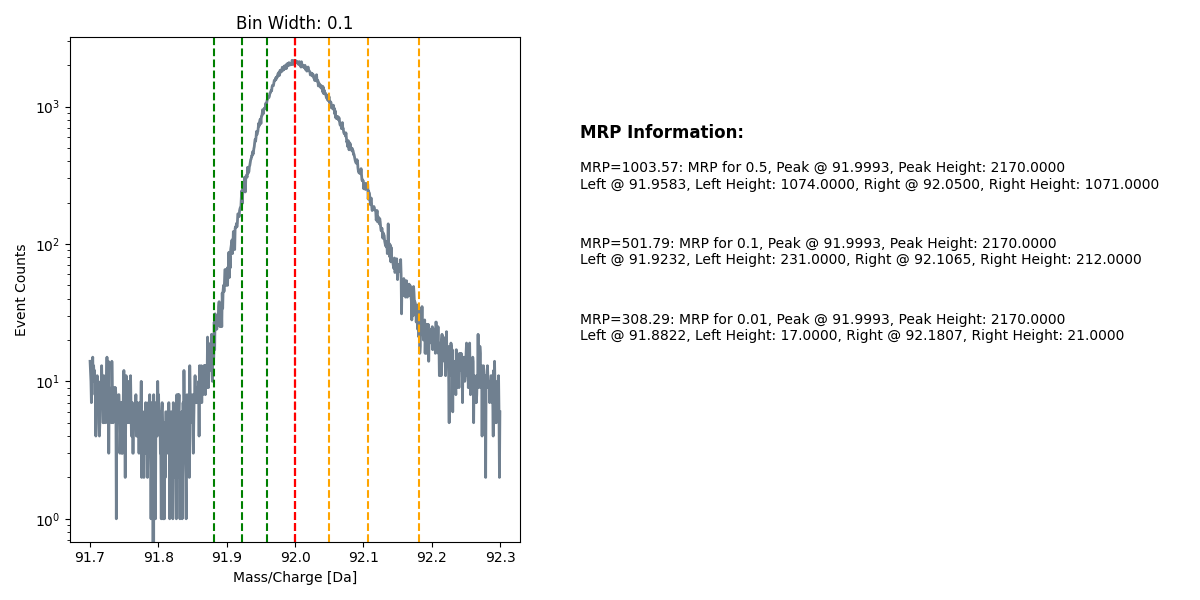

Bin size id: 0.01
Number of found peaks: 1
MRP 0.5: MRP: ***1402.5083*** Peak Location: 92.0068, Peak Height: 257.0000, Left Bound: 91.9685, Left Height: 126.0000, Right Bound: 92.0341, Right Height: 119.0000
Number of found peaks: 1
MRP 0.1: MRP: ***579.8336*** Peak Location: 92.0068, Peak Height: 257.0000, Left Bound: 91.9325, Left Height: 32.0000, Right Bound: 92.0911, Right Height: 25.0000
Number of found peaks: 1
MRP 0.01: MRP: ***395.0177*** Peak Location: 92.0068, Peak Height: 257.0000, Left Bound: 91.9090, Left Height: 0.0000, Right Bound: 92.1419, Right Height: 2.0000


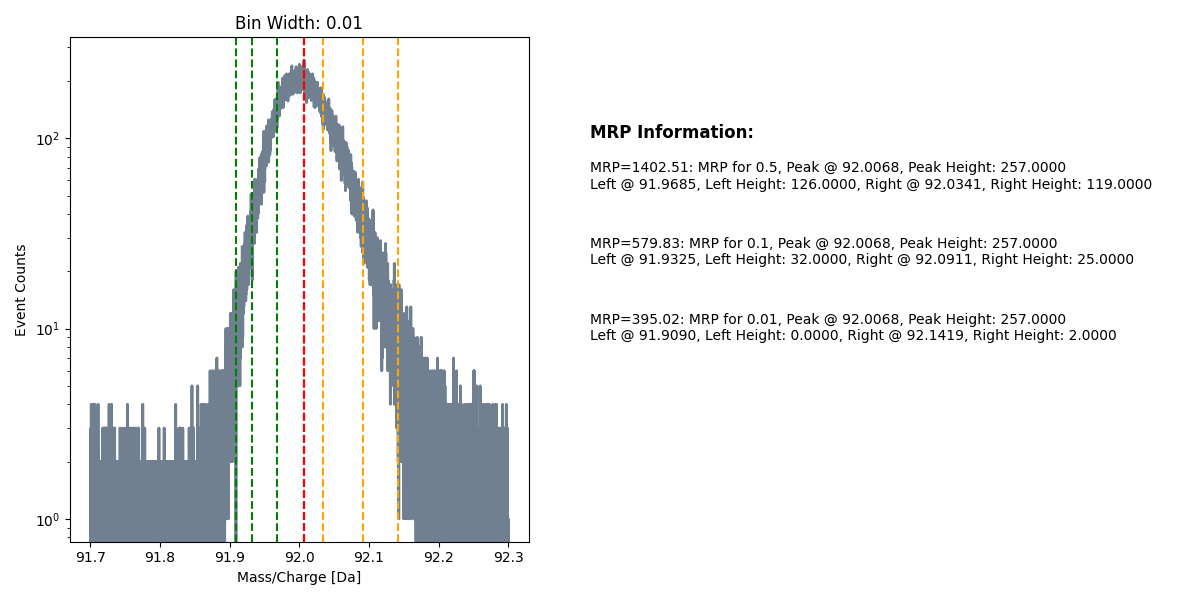

Bin size id: 0.001
Number of found peaks: 1
MRP 0.5: MRP: ***2360860.8460*** Peak Location: 91.9967, Peak Height: 37.0000, Left Bound: 91.9967, Left Height: 18.0000, Right Bound: 91.9967, Right Height: 18.0000
Number of found peaks: 1
MRP 0.1: MRP: ***1326.3263*** Peak Location: 91.9967, Peak Height: 37.0000, Left Bound: 91.9628, Left Height: 3.0000, Right Bound: 92.0321, Right Height: 3.0000
Number of found peaks: 1
MRP 0.01: MRP: ***809.6693*** Peak Location: 91.9967, Peak Height: 37.0000, Left Bound: 91.9466, Left Height: 0.0000, Right Bound: 92.0603, Right Height: 0.0000


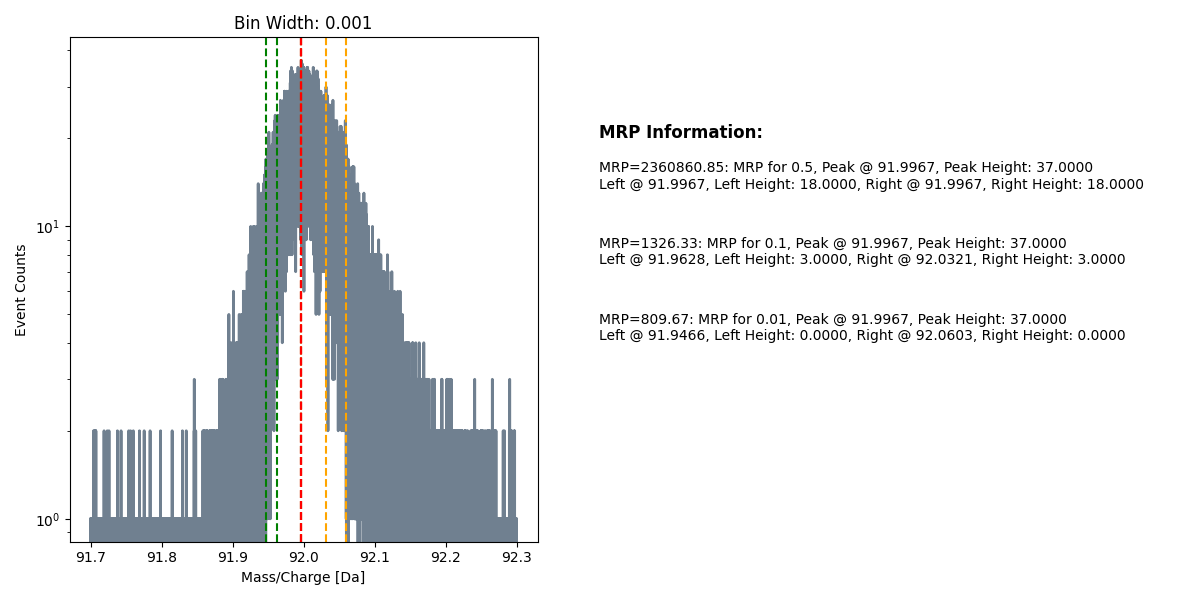

Bin size id: 0.0001
Number of found peaks: 1
MRP 0.5: MRP: ***70841217.7093*** Peak Location: 92.0162, Peak Height: 11.0000, Left Bound: 92.0162, Left Height: 2.0000, Right Bound: 92.0162, Right Height: 2.0000
Number of found peaks: 1
MRP 0.1: MRP: ***47227478.4729*** Peak Location: 92.0162, Peak Height: 11.0000, Left Bound: 92.0162, Left Height: 1.0000, Right Bound: 92.0162, Right Height: 2.0000
Number of found peaks: 1
MRP 0.01: MRP: ***6160105.8936*** Peak Location: 92.0162, Peak Height: 11.0000, Left Bound: 92.0162, Left Height: 0.0000, Right Bound: 92.0162, Right Height: 0.0000


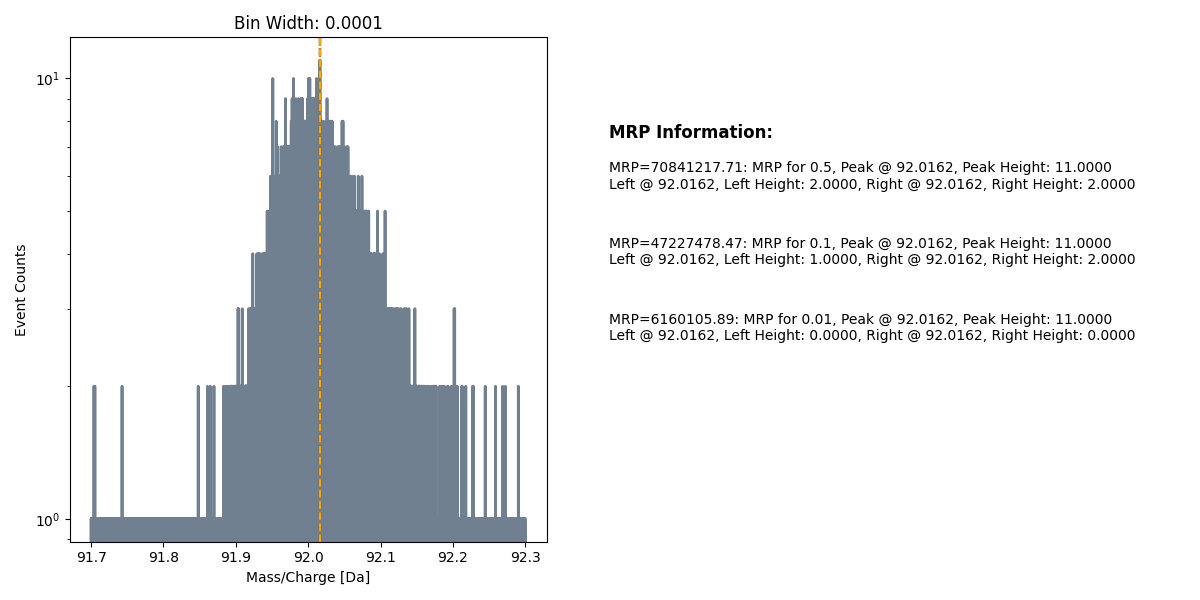

In [118]:
mask = (variables.mc < right_bound) & (variables.mc > left_bound)
aa = variables.mc[mask]

# Define the MRP range and bin size list
mrp_range = [0.5, 0.1, 0.01]
bin_size_list = [0.1, 0.01, 0.001, 0.0001]

# Loop through each bin size in the bin size list
for bin_width in bin_size_list:
    bins = np.linspace(np.min(aa), np.max(aa), round(np.max(aa) / bin_width))
    hist, bin_edges = np.histogram(aa, bins=bins)

    # Create subplots: one for the histogram and one for the MRP information
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns
    
    # Get bin centers for line plot
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Plot the histogram using a line plot
    ax[0].plot(bin_centers, hist, color='slategray', linewidth=2, label='Line Histogram')
    ax[0].set_title(f'Bin Width: {bin_width}')
    ax[0].set_xlabel('Mass/Charge [Da]')
    ax[0].set_ylabel('Event Counts')  # Update label to reflect log scale
    ax[0].set_yscale('log')  # Set y-axis to log scale for consistency with the original histogram

    # Create lists to store the combined MRP and bounds information for the legend
    bound_lines = []
    bound_labels = []
    print('Bin size id:', bin_width)

    # Loop through each MRP value in the range
    for mrp_s in mrp_range:
        mrp_r = 1 - mrp_s

        # Step 1: Find the peaks in the histogram
        peaks, properties = find_peaks(hist, prominence=int(np.max(hist) * 0.8), distance=int(len(bins) / 2), height=0)
        print('Number of found peaks:', len(peaks))

        # Step 2: Calculate peak widths
        peak_width = peak_widths(hist, peaks, rel_height=mrp_r, prominence_data=None)

        # Step 3: Calculate peak prominences
        prominences = peak_prominences(hist, peaks, wlen=None)

        # Step 4: Find the index of the peak with the maximum prominence
        if len(prominences[0]) > 0:
            index_peak_max = np.argmax(prominences[0])

            # Step 5: Calculate the MRP
            mrp_tmp = bin_edges[peaks][index_peak_max] / (bin_edges[round(peak_width[3][index_peak_max])] - 
                                                          bin_edges[round(peak_width[2][index_peak_max])])

            # Step 6: Print the peak location and its left and right bounds
            peak_loc = bin_edges[peaks][index_peak_max]
            left_bound = bin_edges[round(peak_width[2][index_peak_max])]
            right_bound = bin_edges[round(peak_width[3][index_peak_max])]

            # Calculate the heights at the peak, left bound, and right bound
            peak_height = hist[peaks][index_peak_max]
            left_height = hist[round(peak_width[2][index_peak_max])]
            right_height = hist[round(peak_width[3][index_peak_max])]

            print(f"MRP {mrp_s}: MRP: ***{mrp_tmp:.4f}*** Peak Location: {peak_loc:.4f}, Peak Height: {peak_height:.4f}, "
                  f"Left Bound: {left_bound:.4f}, Left Height: {left_height:.4f}, Right Bound: {right_bound:.4f}, Right Height: {right_height:.4f}")

            # Highlight the peak location, left, and right bounds on the plot
            ax[0].axvline(x=peak_loc, color='red', linestyle='--')
            left_line = ax[0].axvline(x=left_bound, color='green', linestyle='--')
            right_line = ax[0].axvline(x=right_bound, color='orange', linestyle='--')

            # Add a single combined legend for MRP, peak, left, and right bounds
            bound_lines.extend([left_line, right_line])
            bound_labels.append(
                f'MRP={mrp_tmp:.2f}: MRP for {mrp_s}, Peak @ {peak_loc:.4f}, Peak Height: {peak_height:.4f}\n'
                f'Left @ {left_bound:.4f}, Left Height: {left_height:.4f}, Right @ {right_bound:.4f}, Right Height: {right_height:.4f}'
            )
            plt.tight_layout()
            plt.savefig(variables.result_path + "/" + variables.result_data_name + "%s_%s.png" %(bin_width, mrp_s), format="png", dpi=600)
            plt.savefig(variables.result_path + "/" + variables.result_data_name + "%s_%s.svg" %(bin_width, mrp_s), format="svg", dpi=600)
        else:
            print(f"MRP {mrp_s}: No peaks found for bin width {bin_width}")

    # Plot the MRP information on the second subplot
    ax[1].axis('off')  # Turn off the axis
    ax[1].text(0.1, 0.8, 'MRP Information:', fontsize=12, fontweight='bold')
    
    # Create a text box for each MRP and bounds
    for i, label in enumerate(bound_labels):
        ax[1].text(0.1, 0.7 - i * 0.15, label, fontsize=10)  # Adjust the y-position for better spacing

    # Adjust layout to make room for the legend on the right side
    plt.tight_layout()

    # Show the plot
    plt.show()

    print('====================================================')


Bin size id: 0.1
Number of found peaks: 1
MRP 0.5: MRP: ***1003.5721*** Peak Location: 91.9993, Peak Height: 2170.0000, Left Bound: 91.9583, Left Height: 1074.0000, Right Bound: 92.0500, Right Height: 1071.0000
Number of found peaks: 1
MRP 0.1: MRP: ***501.7860*** Peak Location: 91.9993, Peak Height: 2170.0000, Left Bound: 91.9232, Left Height: 231.0000, Right Bound: 92.1065, Right Height: 212.0000
Number of found peaks: 1
MRP 0.01: MRP: ***308.2869*** Peak Location: 91.9993, Peak Height: 2170.0000, Left Bound: 91.8822, Left Height: 17.0000, Right Bound: 92.1807, Right Height: 21.0000


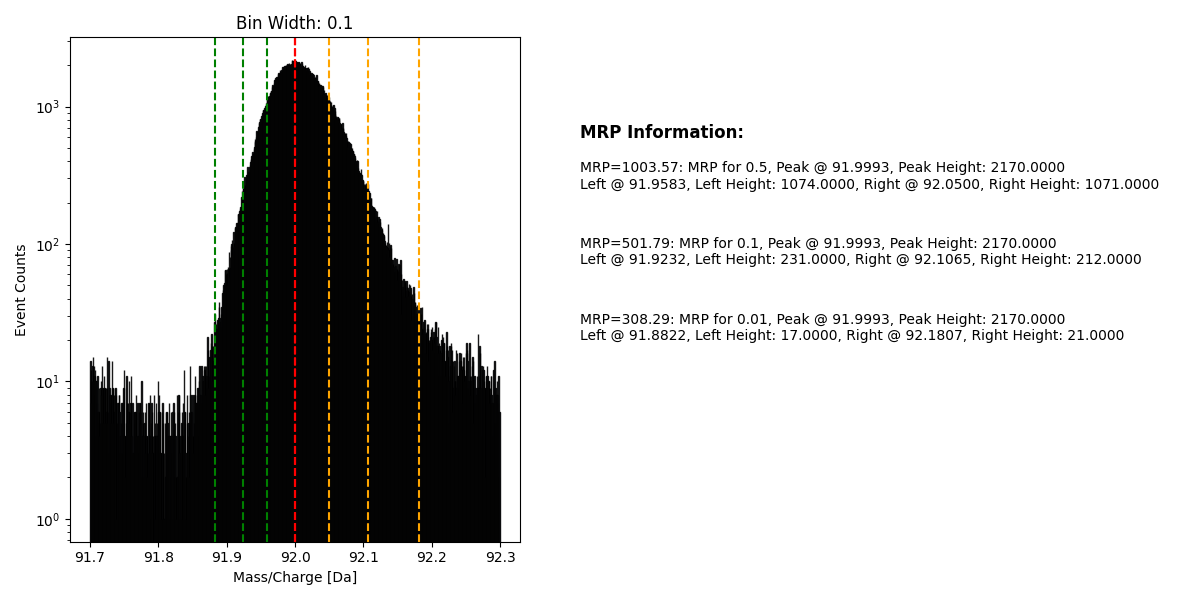

Bin size id: 0.01
Number of found peaks: 1
MRP 0.5: MRP: ***1402.5083*** Peak Location: 92.0068, Peak Height: 257.0000, Left Bound: 91.9685, Left Height: 126.0000, Right Bound: 92.0341, Right Height: 119.0000
Number of found peaks: 1
MRP 0.1: MRP: ***579.8336*** Peak Location: 92.0068, Peak Height: 257.0000, Left Bound: 91.9325, Left Height: 32.0000, Right Bound: 92.0911, Right Height: 25.0000
Number of found peaks: 1
MRP 0.01: MRP: ***395.0177*** Peak Location: 92.0068, Peak Height: 257.0000, Left Bound: 91.9090, Left Height: 0.0000, Right Bound: 92.1419, Right Height: 2.0000


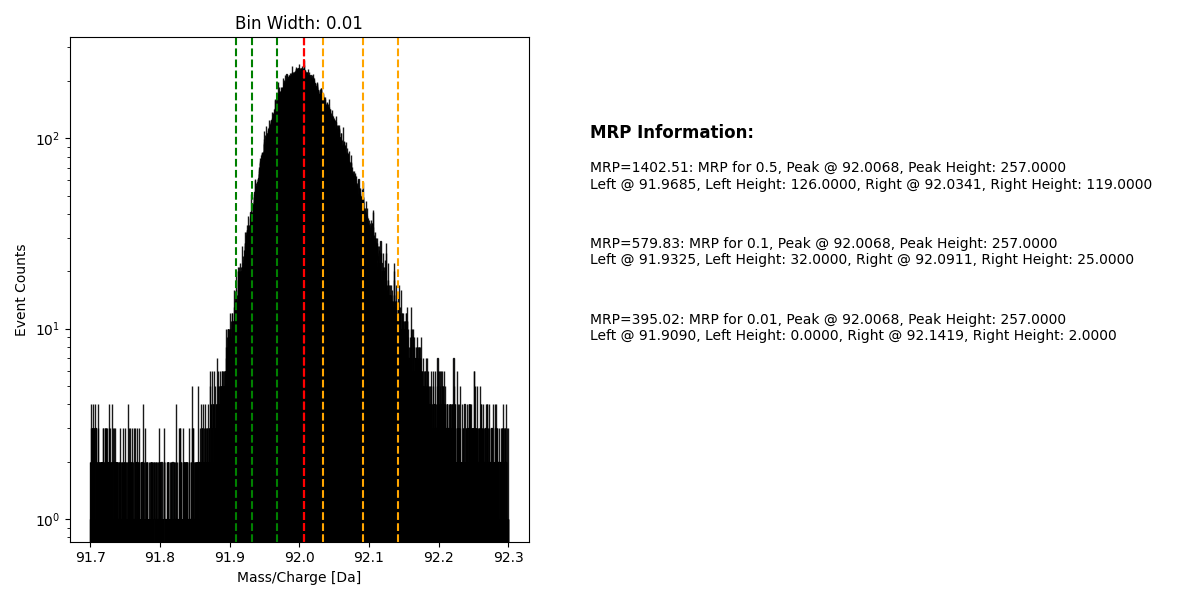

In [120]:
# Define the MRP range and bin size list
mrp_range = [0.5, 0.1, 0.01]
bin_size_list = [0.1, 0.01]

# Loop through each bin size in the bin size list
for bin_width in bin_size_list:
    bins = np.linspace(np.min(aa), np.max(aa), round(np.max(aa) / bin_width))
    hist, bin_edges = np.histogram(aa, bins=bins)
    
    # Create subplots: one for the histogram and one for the MRP information
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns
    
    # Plot the histogram using matplotlib's hist
    ax[0].hist(aa, bins=bins, alpha=0.9, color='slategray', histtype='bar', edgecolor='k', log=True)  # Set y-axis to log
    ax[0].set_title(f'Bin Width: {bin_width}')
    ax[0].set_xlabel('Mass/Charge [Da]')
    ax[0].set_ylabel('Event Counts')  # Update label to reflect log scale
    ax[0].set_yscale('log')  # Set y-axis to log scale for consistency with the original histogram

    # Create lists to store the combined MRP and bounds information for the legend
    bound_lines = []
    bound_labels = []
    print('Bin size id:', bin_width)

    # Loop through each MRP value in the range
    for mrp_s in mrp_range:
        mrp_r = 1 - mrp_s

        # Step 1: Find the peaks in the histogram
        peaks, properties = find_peaks(hist, prominence=int(np.max(hist) * 0.8), distance=int(len(bins) / 2), height=0)
        print('Number of found peaks:', len(peaks))

        # Step 2: Calculate peak widths
        peak_width = peak_widths(hist, peaks, rel_height=mrp_r, prominence_data=None)

        # Step 3: Calculate peak prominences
        prominences = peak_prominences(hist, peaks, wlen=None)

        # Step 4: Find the index of the peak with the maximum prominence
        if len(prominences[0]) > 0:
            index_peak_max = np.argmax(prominences[0])

            # Step 5: Calculate the MRP
            mrp_tmp = bin_edges[peaks][index_peak_max] / (bin_edges[round(peak_width[3][index_peak_max])] -
                                                          bin_edges[round(peak_width[2][index_peak_max])])

            # Step 6: Print the peak location and its left and right bounds
            peak_loc = bin_edges[peaks][index_peak_max]
            left_bound = bin_edges[round(peak_width[2][index_peak_max])]
            right_bound = bin_edges[round(peak_width[3][index_peak_max])]

            # Calculate the heights at the peak, left bound, and right bound
            peak_height = hist[peaks][index_peak_max]
            left_height = hist[round(peak_width[2][index_peak_max])]
            right_height = hist[round(peak_width[3][index_peak_max])]

            print(f"MRP {mrp_s}: MRP: ***{mrp_tmp:.4f}*** Peak Location: {peak_loc:.4f}, Peak Height: {peak_height:.4f}, "
                  f"Left Bound: {left_bound:.4f}, Left Height: {left_height:.4f}, Right Bound: {right_bound:.4f}, Right Height: {right_height:.4f}")

            # Highlight the peak location, left, and right bounds on the plot (but no peak legend)
            ax[0].axvline(x=peak_loc, color='red', linestyle='--')
            left_line = ax[0].axvline(x=left_bound, color='green', linestyle='--')
            right_line = ax[0].axvline(x=right_bound, color='orange', linestyle='--')

            # Add a single combined legend for MRP, peak, left, and right bounds
            bound_lines.extend([left_line, right_line])
            bound_labels.append(
                f'MRP={mrp_tmp:.2f}: MRP for {mrp_s}, Peak @ {peak_loc:.4f}, Peak Height: {peak_height:.4f}\n'
                f'Left @ {left_bound:.4f}, Left Height: {left_height:.4f}, Right @ {right_bound:.4f}, Right Height: {right_height:.4f}'
            )
        else:
            print(f"MRP {mrp_s}: No peaks found for bin width {bin_width}")

    # Plot the MRP information on the second subplot
    ax[1].axis('off')  # Turn off the axis
    ax[1].text(0.1, 0.8, 'MRP Information:', fontsize=12, fontweight='bold')
    
    # Create a text box for each MRP and bounds
    for i, label in enumerate(bound_labels):
        ax[1].text(0.1, 0.7 - i * 0.15, label, fontsize=10)  # Adjust the y-position for better spacing

    # Adjust layout to make room for the legend on the right side
    plt.tight_layout()

    # Show the plot
    plt.show()

    print('====================================================')
